In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('kat2C81.xlsx')
df.columns = ['comment','label']

In [4]:
df = df.dropna()
df['label'] = df['label'].astype(int)
df.reset_index(drop=True)

,comment,label
0,볼스카야에 로봇 퍼시픽림 베낀듯,0
1,도란 도란 관전모드,0
2,이거 아누비스 피라미드에 맥크리와 트레이서 그리고 트레이서와 디바 알맹이가 신문에 ...,1
3,아 이미했구나,0
4,땅밑으로들어갔다고나오면됬어요,0
...,...,...
15128,형이 정말 즐길때느낌이아니야 흙,1
15129,형 텐션뭐야,1
15130,얼마면 형을 살 수 있는 걸까,1
15131,다시생각나서 깔았는데 꿀잼 ㅋㅋ루꿀꿀,1


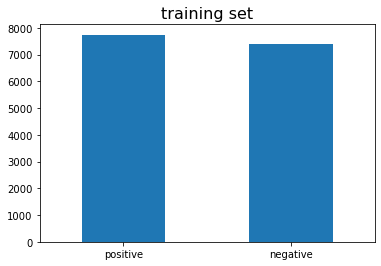

In [5]:
df['label'].value_counts().plot(kind='bar')
plt.xticks([1,0],labels=['negative','positive'],rotation=0)
plt.title('training set',fontsize=16)
plt.savefig('training.png',bbox_inches='tight', dpi=300)

In [6]:
df['label'].value_counts()

1    7743
0    7390
Name: label, dtype: int64

In [7]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df['comment'],df['label'],test_size=0.3)

In [11]:
X_train = df['comment']
y_train = df['label']

In [12]:
# 한글만을 댓글에 남기기 위해 사용한 정규표현식
import re                                           
X_train = X_train.apply(lambda x:re.sub(r'[^ ㄱ-ㅣ가-힣]+'," ",x))

In [13]:
from konlpy.tag import Okt
okt = Okt()

In [14]:
def okt_tokenizer(text):
    # 형태소 단위로 토큰화 작업
    tokens = okt.morphs(text)
    return tokens

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 토큰 생성기는 정의한 함수, 토큰의 단어 크기는 1~2개 단어, 토큰의 출현 빈도가 최소 3번 이상이고 최대 90% 이하인 것들 사용
tfidf = TfidfVectorizer(tokenizer=okt_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf.fit(X_train)
tfidf_train = tfidf.transform(X_train)

In [25]:
# import joblib

# joblib.dump(tfidf, 'tfidf.pkl')

['tfidf.pkl']

# 감성분류 모델 구축

In [16]:
from sklearn.linear_model import LogisticRegression
SA_lr = LogisticRegression(random_state=0)
SA_lr.fit(tfidf_train,y_train)

LogisticRegression(random_state=0)

In [20]:
from sklearn.model_selection import GridSearchCV

params = {"C":[1, 2, 3, 3.5, 4, 4.5, 5]}
SA_lr_grid_cv = GridSearchCV(SA_lr,param_grid=params, cv = 3, scoring='accuracy',verbose=1,n_jobs=-1)
SA_lr_grid_cv.fit(tfidf_train,y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    2.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.6s finished


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': [1, 2, 3, 3.5, 4, 4.5, 5]}, scoring='accuracy',
             verbose=1)

In [21]:
lr_result = pd.DataFrame(SA_lr_grid_cv.cv_results_)

In [22]:
lr_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.265875,0.040647,0.001662,0.000470,1,{'C': 1},0.750842,0.770222,0.776963,0.766009,0.011072,1
1,0.465602,0.033286,0.003343,0.003416,2,{'C': 2},0.752825,0.769429,0.772006,0.764753,0.008500,2
2,0.475453,0.072191,0.000998,0.000815,3,{'C': 3},0.748662,0.768636,0.767645,0.761648,0.009191,3
3,0.502368,0.062439,0.000332,0.000470,3.5,{'C': 3.5},0.747473,0.765860,0.766059,0.759797,0.008715,4
4,0.459551,0.060379,0.003689,0.003101,4,{'C': 4},0.747671,0.762887,0.764076,0.758211,0.007469,5
5,0.322522,0.097090,0.003018,0.003584,4.5,{'C': 4.5},0.746680,0.762688,0.761697,0.757022,0.007324,6
6,0.171025,0.037192,0.000670,0.000947,5,{'C': 5},0.746085,0.761301,0.760111,0.755832,0.006909,7


In [25]:
SA_lr_grid_cv.best_score_

0.7668680658110838

train+test를 모두 학습에 이용

In [21]:
X = df['comment']
y = df['label']
tfidf.fit(X)
tfidf_all = tfidf.transform(X)
SA_lr_all = LogisticRegression(random_state=0)
SA_lr_all.fit(tfidf_all,y)

LogisticRegression(random_state=0)

In [2]:
import re
def emotion_predict(sentence):
    st = re.compile(r'[ㄱ-ㅣ가-힣]+').findall(sentence)
    st = [" ".join(st)]
    st_tfidf = tfidf.transform(st)
    st_predict = SA_lr_all.predict(st_tfidf)
    proba = SA_lr_all.predict_proba(st_tfidf)
    if st_predict == 0:
        print('{}  ->  부정, {}'.format(sentence,proba[0][0]))
    else:
        print('{}  ->  긍정, {}'.format(sentence,proba[0][1]))

In [4]:
def emotion_predict(sentence):
    st = re.compile(r'[ㄱ-ㅣ가-힣]+').findall(sentence)
    st = [" ".join(st)]
    st_tfidf = tfidf.transform(st)
    st_predict = clf.predict(st_tfidf)
    proba = clf.predict_proba(st_tfidf)
    if st_predict == 0:
        print('{}  ->  부정, {}'.format(sentence,proba[0][0]))
    else:
        print('{}  ->  긍정, {}'.format(sentence,proba[0][1]))

In [8]:
sentences = ['아 빨리 자야하는데ㅠㅠㅠㅠㅠ','오타쿠','개미쳤네ㅋㅋ','노잼','영상편집 뭐같이 하네','대박 재밌어요',
           '이게 재밌냐?','왁물원ㅋㅋ','꿀잼','ㅆㅅㅌㅊ','아차차']
for sentence in sentences:
    emotion_predict(sentence)

아 빨리 자야하는데ㅠㅠㅠㅠㅠ  ->  긍정, 0.8354397540743079
오타쿠  ->  부정, 0.5884023954470563
개미쳤네ㅋㅋ  ->  긍정, 0.9956057725589282
노잼  ->  부정, 0.875307767677531
영상편집 뭐같이 하네  ->  부정, 0.8147066859949833
대박 재밌어요  ->  긍정, 0.511165485026415
이게 재밌냐?  ->  부정, 0.6786847514694185
왁물원ㅋㅋ  ->  긍정, 0.7552098247553755
꿀잼  ->  긍정, 0.8577958641236386
ㅆㅅㅌㅊ  ->  부정, 0.6801510340888705
아차차  ->  부정, 0.8272933192943654


In [27]:
# 모델 저장
import joblib

joblib.dump(SA_lr_all, 'SA_lr.pkl')

['SA_lr.pkl']

In [28]:
# 모델 load
clf = joblib.load('SA_lr.pkl')

youtube api로 저장한 데이터프레임에 예측 --> 영상에 대한 호불호 판단<br>
시간대별 좋아요, 대댓수 --> 이것을 plot으로 그리되 해당 댓글을 호불호 판단해 긍/부정 색깔 입히기(between)<br>
전체 영상별 호불호 추이(영상에는 업로드 날짜가 있음)

# 훈련 이후

In [1]:
import joblib
from konlpy.tag import Okt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
okt = Okt()
def okt_tokenizer(text):
    # 형태소 단위로 토큰화 작업
    tokens = okt.morphs(text)
    return tokens


tfidf = joblib.load('tfidf.pkl')
clf = joblib.load('SA_lr.pkl')

In [33]:
def find_time(strings):
    idx_start = strings.find('">')+2
    idx_end = strings.find('</a')
    if idx_start==1:
        return 
    else:
        time_string = strings[idx_start:idx_end]
        if 'http' not in time_string:
            return time_string
        else:
            return
def split_time_hour(x):
    if len(x.split(':'))==3:
        return x.split(':')[-3]
    else:
        return 0
def split_time_minute(x):
    return x.split(':')[-2]
def split_time_second(x):
    return x.split(':')[-1]

def transform_from_time(x):
    # 분:초로 구성
    hour = int(split_time_hour(x))
    minute = int(split_time_minute(x))
    second = int(split_time_second(x))
    return hour*3600+minute*60+second

def transform_to_time(x):
    minute = str(x//60)
    second = str(x%60)
    strings = '{}:{}'.format(minute,second.zfill(2))
    return strings

def plot_freq(grouped):
    grouped_input = grouped.copy()
    grouped_input['주목_시간'] = grouped_input['주목_시간'].map(transform_from_time)
    grouped_input['합'] = grouped_input['좋아요']+grouped_input['답글수']
    
    # 10초 단위로 합산해서 표현
    end_time = grouped_input['주목_시간'].iloc[-1]
    intervals = range(0,end_time+1,10)
    grouped_input['구간'] = pd.Categorical(pd.cut(grouped_input['주목_시간'],bins = intervals)).codes
    func_dict = {'주목_시간':'mean','합':'sum'}
    grouped_temp = grouped_input.groupby('구간').agg(func_dict)
    grouped_temp['주목_시간'] = grouped_temp['주목_시간'].round(0).astype(int)
    grouped_temp = grouped_temp.sort_values(by=['주목_시간'])
    
    x = grouped_temp['주목_시간'].tolist()
    y = grouped_temp['합'].tolist()
    plt.plot(x,y)
    if len(x)>15:
        show_interval = len(x)//15
    else:
        show_interval = 1
    plt.xticks(x[::show_interval],labels = pd.Series(x).map(transform_to_time).tolist()[::show_interval],rotation='90')
    
    

def generate_comment_df(video_id,api_key):
    # 대댓글은 포함되지 않는다.
    api_obj = build('youtube', 'v3', developerKey=api_key)

    comments = list()
    response = api_obj.commentThreads().list(part='snippet,replies', videoId=video_id, maxResults=100).execute()
        
    while response:
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            replycount = item['snippet']['totalReplyCount']
            comments.append([comment['authorDisplayName'], comment['publishedAt'], comment['likeCount'],replycount,comment['textDisplay']])
 
        if 'nextPageToken' in response:
            # 그다음 페이지 100개씩 받아옴
            response = api_obj.commentThreads().list(part='snippet,replies', videoId=video_id, pageToken=response['nextPageToken'], maxResults=100).execute()
        else:
            break
    df = pd.DataFrame(comments,columns = ['작성자','작성일시','좋아요','답글수','내용'])
        
    df['주목_시간'] = df['내용'].map(find_time)
    grouped = df.groupby('주목_시간').sum()[['좋아요','답글수']]
    if grouped.index[0] == '':
        grouped = grouped.drop(labels = '')            
    grouped_temp = grouped.reset_index()

    grouped_temp['분'] = grouped_temp['주목_시간'].map(split_time_minute).astype(int)
    grouped_temp['분'] += grouped_temp['주목_시간'].map(split_time_hour).astype(int)*60
    grouped_temp['초'] = grouped_temp['주목_시간'].map(split_time_second).astype(int)
    grouped_temp.sort_values(['분','초'],inplace=True)
    grouped_temp['주목_시간'] = grouped_temp['분'].astype('str')+':'+grouped_temp['초'].astype('str')
    grouped_temp.reset_index(drop=True,inplace=True)
    grouped_temp.drop(['분','초'],axis=1,inplace=True)
    return grouped_temp, df

In [34]:
import pickle
with open('result0428.p','rb') as file:
    data = pickle.load(file)

In [35]:
data.keys()

dict_keys(['우왁굳', '침착맨'])

In [36]:
data['우왁굳'].keys()

dict_keys(['BSE9_bVYzhw', 'wiB8GFFDxu8', 'qpnXAE5dxQY'])

In [37]:
temp_df = data['우왁굳']['BSE9_bVYzhw']['df']
temp_df.head()

,작성자,작성일시,좋아요,답글수,내용,주목_시간
0,우왁굳의 게임방송,2021-04-04T17:07:19Z,977,26,웨딩샵 디스하는 내용은 아닙니다 ㅎㅎ 초보 예비부부라서 당황할 수 있는 내용의 공감...,None
1,권태욱,2021-04-27T03:26:36Z,0,0,기존나셈 : 왁귣<br />유리멘탈 :빛젤,None
2,강도깨비,2021-04-25T02:47:38Z,0,0,솔직히 왁형 말만 들으면 드레스 ㅈㄴ 비싼거네,None
3,보충제에 밥말아먹기,2021-04-23T21:55:11Z,1,0,역시 예식장 중에 양꼬치들 개 많네 ㅋㅋㅋㅋㅋ망해라,None
4,잉,2021-04-23T07:47:40Z,0,0,ㄹㅇ 편집하는 사람 개천재 아니냐<br />그냥 앉자서 노가리 까는걸 이렇게 이해 ...,None


In [38]:
# map을 안쓰고 한번에 변환할 수 있게 바꿀 것
def emotion_predict(sentence):
    st = re.compile(r'[ㄱ-ㅣ가-힣]+').findall(sentence)
    st = [" ".join(st)]
    st_tfidf = tfidf.transform(st)
    st_predict = clf.predict(st_tfidf)
    decision_power = clf.decision_function(st_tfidf)
    return decision_power[0]

In [39]:
temp_df['pos/neg'] = temp_df['내용'].map(emotion_predict)

In [40]:
temp_df.head()

,작성자,작성일시,좋아요,답글수,내용,주목_시간,pos/neg
0,우왁굳의 게임방송,2021-04-04T17:07:19Z,977,26,웨딩샵 디스하는 내용은 아닙니다 ㅎㅎ 초보 예비부부라서 당황할 수 있는 내용의 공감...,None,0.855512
1,권태욱,2021-04-27T03:26:36Z,0,0,기존나셈 : 왁귣<br />유리멘탈 :빛젤,None,-0.757993
2,강도깨비,2021-04-25T02:47:38Z,0,0,솔직히 왁형 말만 들으면 드레스 ㅈㄴ 비싼거네,None,0.446540
3,보충제에 밥말아먹기,2021-04-23T21:55:11Z,1,0,역시 예식장 중에 양꼬치들 개 많네 ㅋㅋㅋㅋㅋ망해라,None,1.034725
4,잉,2021-04-23T07:47:40Z,0,0,ㄹㅇ 편집하는 사람 개천재 아니냐<br />그냥 앉자서 노가리 까는걸 이렇게 이해 ...,None,1.323016


total : 279.8133043884177


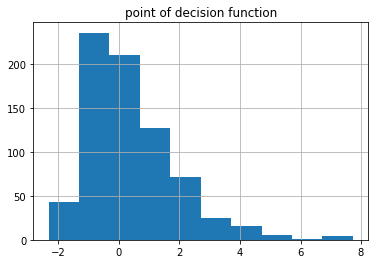

In [30]:
temp_df['pos/neg'].hist()
plt.title('point of decision function')
print('total : {}'.format(np.sum(temp_df['pos/neg'])))

In [32]:
temp_df['pos/neg'].map(lambda x:1 if x>=0 else 0).value_counts()

1    386
0    353
Name: pos/neg, dtype: int64

(0.0, 450.0)

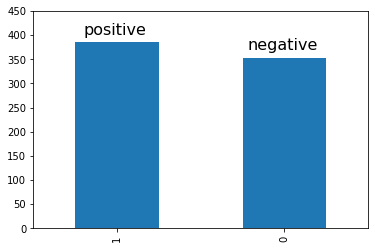

In [64]:
temp_df['pos/neg'].map(lambda x:1 if x>=0 else 0).value_counts().plot(kind='bar')
plt.text(-0.20,400,'positive',fontdict={'fontsize':16})
plt.text(0.78,370,'negative',fontdict={'fontsize':16})
plt.ylim([0,450])

In [72]:
grouped = temp_df.groupby('주목_시간').sum()[['좋아요','답글수','pos/neg']]
if grouped.index[0] == '':    
    grouped = grouped.drop(labels = '')            
grouped_temp = grouped.reset_index()

grouped_temp['분'] = grouped_temp['주목_시간'].map(split_time_minute).astype(int)
grouped_temp['분'] += grouped_temp['주목_시간'].map(split_time_hour).astype(int)*60
grouped_temp['초'] = grouped_temp['주목_시간'].map(split_time_second).astype(int)
grouped_temp.sort_values(['분','초'],inplace=True)
grouped_temp['주목_시간'] = grouped_temp['분'].astype('str')+':'+grouped_temp['초'].astype('str')
grouped_temp.reset_index(drop=True,inplace=True)
grouped_temp.drop(['분','초'],axis=1,inplace=True)
    

In [73]:
    
grouped_input = grouped_temp.copy()
grouped_input['주목_시간'] = grouped_input['주목_시간'].map(transform_from_time)
grouped_input['합'] = grouped_input['좋아요']+grouped_input['답글수']
  
# 10초 단위로 합산해서 표현
end_time = grouped_input['주목_시간'].iloc[-1]
intervals = range(0,end_time+1,10)
grouped_input['구간'] = pd.Categorical(pd.cut(grouped_input['주목_시간'],bins = intervals)).codes
func_dict = {'주목_시간':'mean','합':'sum','pos/neg':'sum'}
grouped_temp = grouped_input.groupby('구간').agg(func_dict)
grouped_temp

,주목_시간,합,pos/neg
구간,,,
0,8.500000,1,5.038383
4,41.000000,0,0.458618
7,78.000000,5,-1.741076
8,87.000000,170,3.916730
9,97.500000,2,-0.548200
10,103.500000,239,5.304775
15,152.000000,0,-0.754466
16,168.000000,26,-1.766920
23,240.000000,0,-0.754466


In [74]:
grouped_temp['주목_시간'] = grouped_temp['주목_시간'].round(0).astype(int)
grouped_temp = grouped_temp.sort_values(by=['주목_시간'])
    
x = grouped_temp['주목_시간'].tolist()
y = grouped_temp['합'].tolist()
color = (grouped_temp['pos/neg']).tolist()

([<matplotlib.axis.XTick at 0x1a6d9c4c700>,
 [Text(8, 0, '0:08'),
  Text(78, 0, '1:18'),
  Text(98, 0, '1:38'),
  Text(152, 0, '2:32'),
  Text(240, 0, '4:00'),
  Text(277, 0, '4:37'),
  Text(333, 0, '5:33'),
  Text(384, 0, '6:24'),
  Text(506, 0, '8:26'),
  Text(584, 0, '9:44'),
  Text(613, 0, '10:13'),
  Text(660, 0, '11:00'),
  Text(698, 0, '11:38'),
  Text(720, 0, '12:00'),
  Text(745, 0, '12:25'),
  Text(812, 0, '13:32'),
  Text(836, 0, '13:56'),
  Text(1220, 0, '20:20')])

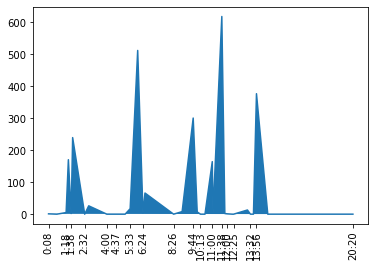

In [86]:
plt.plot(x,y)
plt.fill(x,y)
if len(x)>15:
    show_interval = len(x)//15
else:
    show_interval = 1
plt.xticks(x[::show_interval],labels = pd.Series(x).map(transform_to_time).tolist()[::show_interval],rotation='90')

- 해당 좋아요+대댓글(반응)을 나타내는 그래프에 긍정, 부정 점수가 표시되었다고 하자.( 너무 복잡하면 decision_function의 결과대신 긍정/부정인지 여부만으로 두가지 색으로 칠할 것)
- 댓글 전부에 time 정보와 votes 정보가 있으니 인기나 호감도가 상승하는 추이를 살펴볼 수 있다.(절대적인 양)

## 개요
1. 유튜브 댓글 전부 -> 전체적인 호감도나 인기 성향
2. 개별 동영상마다 호감도나 인기 파악
3. 개별 동영상의 호응이 좋았던(나빴던) 부분 표시 -> 구체적인 피드백, ex) 어느 동영상의 어느 부분이 특히 인기있더라
    - 실제 그 부분 캡쳐 및 관련 댓글 살필 것
4. 전체 동영상내 동일 댓글 작성자의 비율을 파악해 팬의 비율이 많다는 것 얘기함

5. 미비점 : 유튜버마다 시청자들이 즐겨쓰는 유행어들이 상이해 일관된 감성분석이 어려움, 학습데이터 구축에 수작업이 많이 들어감

### 남은 것
- (완) 댓글 전부에 대한 time, votes로 추이 살피기 -> 자료확보, 그래프만 그리면 됨
- (미완) 다른 색깔로 matplotlib.pyplot.plot 칠하는법 살피기, where을 이용하면 조건을 걸 수 있다. 4분위로 나눠 색칠
- (미실시) 2,3번은 조금더 많은 영상에 대해 확보
- (미완) 4번은 실시 - entire_evaluation에서 author명 체크
- (미실시) 보고서 작성 : 워드클라우드 빼먹지 말기, 분류기 성능을 보여주기 위해 emotion_predict 함수 선보이기

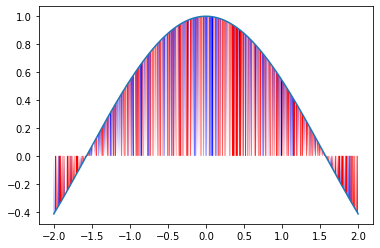

In [29]:
color = np.random.rand(1000)
color_num = pd.cut(color,4).codes
x = np.linspace(-2,2,1000)
y = np.cos(x)
y_bottom = y*0
fig,ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x,y,y_bottom,where = color_num<2, facecolor = 'red',interpolate=True)
ax.fill_between(x,y,y_bottom,where = color_num>=3, facecolor = 'blue',interpolate=True)

시도 :  barchart를 그림 -> color를 4등분 -> 각 숫자를 dictionary로 만든 뒤 coloring